In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import datetime
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt



# Preparing Target

In [2]:
start = datetime.datetime(2005, 1, 1)
end = datetime.datetime(2024, 12, 31)

# Load data from FRED
home_price = pd.DataFrame(pdr.DataReader('CSUSHPISA', 'fred', start, end))

In [3]:
home_price

,CSUSHPISA
DATE,
2005-01-01,161.289
2005-02-01,163.346
2005-03-01,165.814
2005-04-01,167.503
2005-05-01,169.352
...,...
2024-08-01,322.282
2024-09-01,323.282
2024-10-01,324.466


In [4]:
home_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2005-01-01 to 2024-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CSUSHPISA  240 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


>Above is the target varible we are going to make analysis based on and also make prediction on.
  Those are of size 240 for every month in last 20 years from 2005 to 2024.


In [5]:
home_price = home_price.rename(columns={'CSUSHPISA': 'home_price'})

# Feature analysis

These Features will be taken from the fred for analysis and preparing the regression model

## Bivariate Analysis

## Population

In [6]:
population = pd.DataFrame(pdr.DataReader('POPTHM', 'fred', start, end)).rename(columns={'POPTHM': 'population'})
population.head()

,population
DATE,
2005-01-01,294768
2005-02-01,294955
2005-03-01,295149
2005-04-01,295359
2005-05-01,295582


In [7]:
population.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2005-01-01 to 2024-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   population  240 non-null    int64
dtypes: int64(1)
memory usage: 3.8 KB


In [8]:
corr = home_price['home_price'].corr(population['population'])
corr

0.7441247916151423

>By default 'population' will have strong correlation with everything but it won't tell much on information.<br>But this can be used as threshold of 0.75 for further variables

In [9]:
X = sm.add_constant(population['population'])

model = sm.OLS(home_price['home_price'], X).fit()

alpha = model.params['const']
beta = model.params[population['population'].name]
r_squared = model.rsquared
p_value = model.pvalues[population['population'].name]
corr = np.corrcoef(population['population'], home_price['home_price'])[0, 1]

In [10]:
print(f'alpha:{alpha}')
print(f'beta:{beta}')
print(f'r_squared:{r_squared}')
print(f'p_value:{p_value}')
print(f'corr:{corr}')


alpha:-799.298590136694
beta:0.0031204095282167344
r_squared:0.5537217054962793
p_value:1.3905580181162605e-43
corr:0.7441247916151423


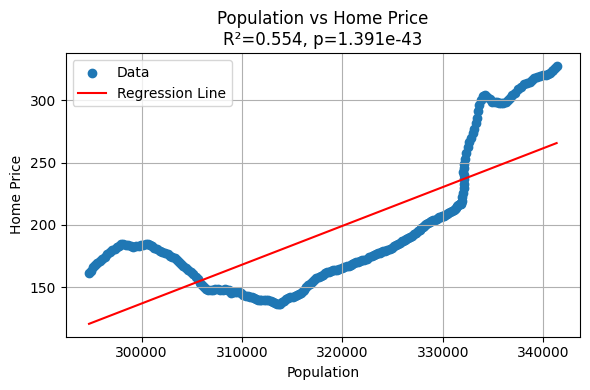

In [11]:
plt.figure(figsize=(6, 4))
plt.scatter(population['population'], home_price['home_price'], label='Data')
y_pred = alpha + beta * population['population']
plt.plot(population['population'], y_pred, color='red', label='Regression Line')
plt.xlabel('Population')
plt.ylabel('Home Price')
plt.title(f'Population vs Home Price\nR²={r_squared:.3f}, p={p_value:.3e}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

> Well after noticing regression line we Population can be considered but better feature will be obtained

# preparing resuable script

In [12]:
def analysis(feature_series, target_series):
    x = feature_series
    y = target_series
    feature_name = x.name
    target_name = y.name
    
    X = sm.add_constant(x)

    model = sm.OLS(y, X).fit()

    alpha = model.params['const']
    beta = model.params[feature_name]
    r_squared = model.rsquared
    p_value = model.pvalues[feature_name]
    corr = np.corrcoef(x, y)[0, 1]

    print(f"Correlation: {corr:.4f}")
    print(f"Intercept (α): {alpha:.4f}")
    print(f"Slope (β): {beta:.4f}")
    print(f"R² Score: {r_squared:.4f}")
    print(f"P-value: {p_value:.4e}")
    print("-" * 40)

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, label='Data')
    y_pred = alpha + beta * x
    plt.plot(x, y_pred, color='red', label='Regression Line')
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.title(f'{feature_name} vs {target_name}\nR²={r_squared:.3f}, p={p_value:.3e}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Inflation

Inflation can be one of the best indicator

In [13]:
inflation = pd.DataFrame(pdr.DataReader('CPIAUCSL', 'fred', start, end)).rename(columns={'CPIAUCSL': 'Inflation'})

In [14]:
inflation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2005-01-01 to 2024-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inflation  240 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


Correlation: 0.8933
Intercept (α): -170.9257
Slope (β): 1.5218
R² Score: 0.7980
P-value: 1.2846e-84
----------------------------------------


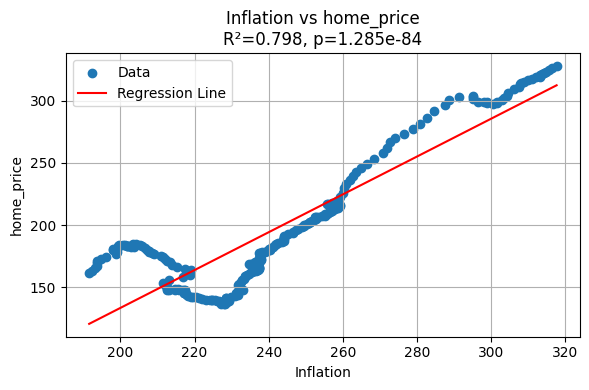

In [15]:
analysis(inflation['Inflation'], home_price['home_price'])

> as you can see inflation make far better candidate, so we can add it to features

In [16]:
FEATURES = {
    "Inflation" : 'CPIAUCSL'
}

### MEDIAN hourly wages

In [17]:
wages = pd.DataFrame(pdr.DataReader('FRBATLWGTUMHWGO', 'fred', start, end)).rename(columns={'FRBATLWGTUMHWGO': 'wages'})
wages.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2005-01-01 to 2024-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wages   240 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


In [18]:
wages.head()

,wages
DATE,
2005-01-01,3.9
2005-02-01,3.4
2005-03-01,3.4
2005-04-01,3.7
2005-05-01,3.8


Correlation: 0.7992
Intercept (α): 68.1422
Slope (β): 36.8778
R² Score: 0.6387
P-value: 1.5873e-54
----------------------------------------


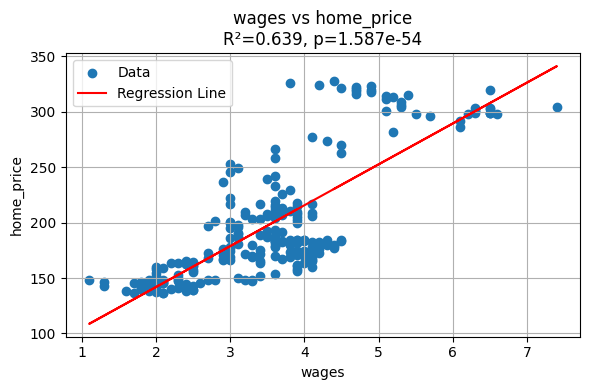

In [19]:
analysis(wages['wages'], home_price['home_price'])

> not so perfect but will go along well with next variable of mortage rate

In [20]:
FEATURES['wages'] = 'FRBATLWGTUMHWGO'

### Mortage

In [21]:
mortage = pd.DataFrame(pdr.DataReader('MORTGAGE30US', 'fred', start, end)).rename(columns={'MORTGAGE30US': 'mortage'})
mortage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1043 entries, 2005-01-06 to 2024-12-26
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mortage  1043 non-null   float64
dtypes: float64(1)
memory usage: 16.3 KB


In [22]:
# resmaple them
mortage.index = pd.to_datetime(mortage.index)
mortage = mortage.resample('MS').mean()

In [23]:
mortage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2005-01-01 to 2024-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mortage  240 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


> perfect

In [24]:
mortage.head()

,mortage
DATE,
2005-01-01,5.7100
2005-02-01,5.6275
2005-03-01,5.9280
2005-04-01,5.8550
2005-05-01,5.7200


Correlation: 0.3024
Intercept (α): 133.5575
Slope (β): 13.4497
R² Score: 0.0914
P-value: 1.8195e-06
----------------------------------------


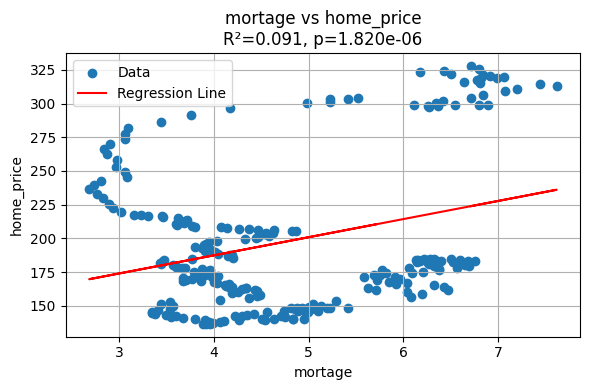

In [25]:
analysis(mortage['mortage'], home_price['home_price'])

> not doing good, it lack explantory power showed by R2 value

### Unemployment

> many studies show unemployment i also major let's check it

In [26]:
unemployment = pd.DataFrame(pdr.DataReader('UNRATE', 'fred', start, end)).rename(columns={'UNRATE': 'unemployment'})
unemployment.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2005-01-01 to 2024-12-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unemployment  240 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


Correlation: -0.5838
Intercept (α): 285.2091
Slope (β): -15.0233
R² Score: 0.3408
P-value: 2.5363e-23
----------------------------------------


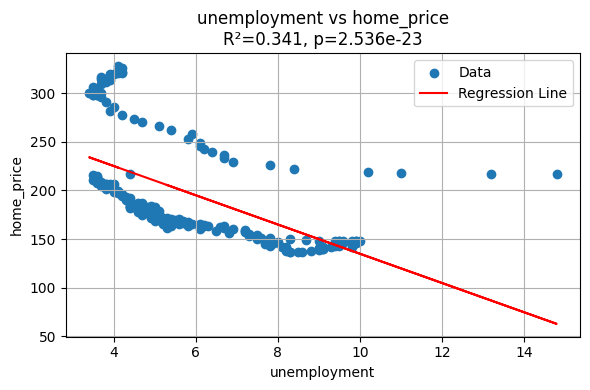

In [27]:
analysis(unemployment['unemployment'], home_price['home_price'])

> not best indicator but we will see how it do with other

In [28]:
FEATURES['unemployment'] = 'UNRATE'

### Personal saving 

In [29]:
saving = pd.DataFrame(pdr.DataReader('PMSAVE', 'fred', start, end)).rename(columns={'PMSAVE': 'saving'})
saving.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2005-01-01 to 2024-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   saving  240 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


Correlation: 0.2534
Intercept (α): 180.5565
Slope (β): 0.0198
R² Score: 0.0642
P-value: 7.2026e-05
----------------------------------------


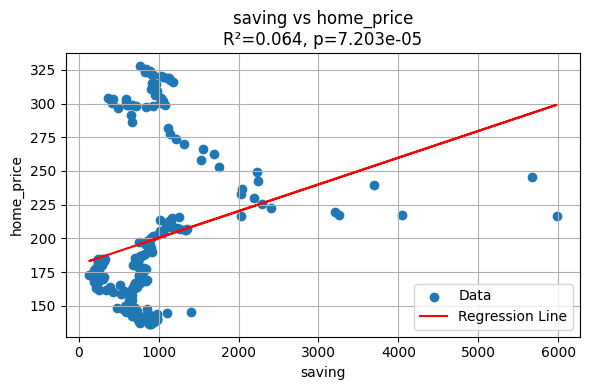

In [30]:
analysis(saving['saving'], home_price['home_price'])

> also failing to explain much of information


#### Top Performing features are:

In [31]:
FEATURES

{'Inflation': 'CPIAUCSL', 'wages': 'FRBATLWGTUMHWGO', 'unemployment': 'UNRATE'}

## Multivariate Analysis

In [36]:
df = pd.concat([inflation, wages, unemployment, mortage, population, home_price], axis=1)

In [37]:
df

,Inflation,wages,unemployment,mortage,population,home_price
DATE,,,,,,
2005-01-01,191.600,3.9,5.3,5.7100,294768,161.289
2005-02-01,192.400,3.4,5.4,5.6275,294955,163.346
2005-03-01,193.100,3.4,5.2,5.9280,295149,165.814
2005-04-01,193.700,3.7,5.2,5.8550,295359,167.503
2005-05-01,193.600,3.8,5.1,5.7200,295582,169.352
...,...,...,...,...,...,...
2024-08-01,314.131,4.7,4.2,6.5000,340637,322.282
2024-09-01,314.851,4.9,4.1,6.1800,340825,323.282
2024-10-01,315.564,4.2,4.1,6.4280,341002,324.466


<Axes: >

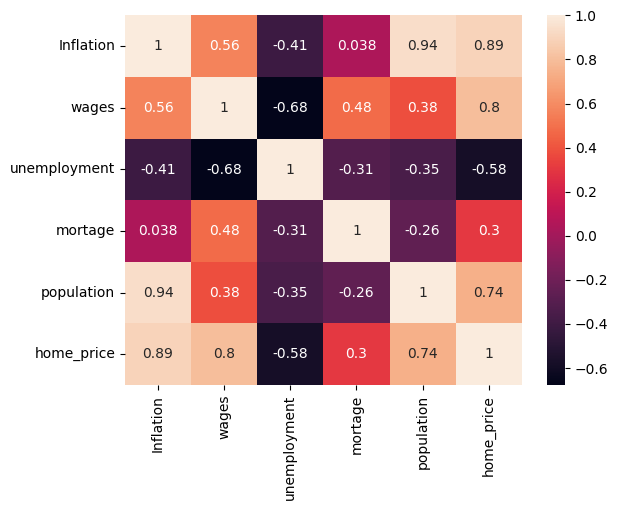

In [38]:
sns.heatmap(data=df.corr(), annot=True)

# Building Data Model

In [42]:
X = df[['Inflation', 'wages', 'unemployment', 'mortage', 'population']]
y = df['home_price']

In [43]:
X = sm.add_constant(X)

In [44]:
model = sm.OLS(y, X).fit()

In [45]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             home_price   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     721.2
Date:                Fri, 13 Jun 2025   Prob (F-statistic):          5.98e-140
Time:                        17:23:30   Log-Likelihood:                -966.30
No. Observations:                 240   AIC:                             1945.
Df Residuals:                     234   BIC:                             1965.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          290.2870     98.866      2.936   

> Detailed Information

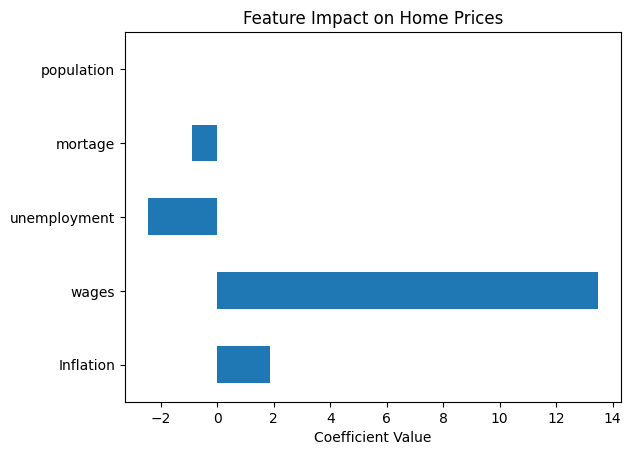

In [46]:
coeffs = model.params[1:]
coeffs.plot(kind='barh')
plt.title('Feature Impact on Home Prices')
plt.xlabel('Coefficient Value')
plt.show()

> here wages are primary factor affecting the prices